In [18]:
# imports
import os
import datetime
import logging
from pprint import pprint

import numpy as np
from citeomatic.serialization import model_from_directory
from citeomatic.neighbors import EmbeddingModel, ANN
from citeomatic.ranker import Ranker
from citeomatic.common import PAPER_EMBEDDING_MODEL, CITATION_RANKER_MODEL, DatasetPaths
from citeomatic import file_util
from citeomatic.candidate_selectors import CandidateSelector, ANNCandidateSelector
from citeomatic.common import DatasetPaths
from citeomatic.corpus import Corpus
from citeomatic.features import DataGenerator
from citeomatic.features import Featurizer
from citeomatic.models import layers
from citeomatic.models.options import ModelOptions
from citeomatic.neighbors import EmbeddingModel, ANN
from citeomatic.ranker import Ranker
from citeomatic.serialization import model_from_directory
from citeomatic.utils import import_from
from citeomatic.eval_metrics import precision_recall_f1_at_ks, average_results

# directories
base_dir = '/net/nfs.corp/s2-research/citeomatic/naacl2017/open_corpus/models/'
sha_suffix = '9c07a34904aedb46f754ea11d8cce50619f31b74'
embedder_name = 'paper_embedder'
ranker1_name = 'citation_ranker_canonical'
ranker2_name = 'citation_ranker_canonical-metadata'


embedder_dir = base_dir + embedder_name
ranker1_dir = base_dir + ranker1_name + '_' + sha_suffix
ranker2_dir = base_dir + ranker2_name + '_' + sha_suffix

In [15]:
# load corpus, featurizer and the two models
dp = DatasetPaths()
corpus = Corpus.load_pkl(dp.get_pkl_path('oc'))
featurizer1, models1 = model_from_directory(ranker1_dir, on_cpu=True)
featurizer2, models2 = model_from_directory(ranker2_dir, on_cpu=True)
featurizer_for_ann, ann_models = model_from_directory(embedder_dir, on_cpu=True)

Loading model from /net/nfs.corp/s2-research/citeomatic/naacl2017/open_corpus/models/citation_ranker_canonical_9c07a34904aedb46f754ea11d8cce50619f31b74 
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
query-title-txt (InputLayer)     (None, None)          0                                            
____________________________________________________________________________________________________
candidate-title-txt (InputLayer) (None, None)          0                                            
____________________________________________________________________________________________________
query-abstract-txt (InputLayer)  (None, None)          0                                            
____________________________________________________________________________________________________
candidate-abstract-txt (InputLay (None,

Loading model from /net/nfs.corp/s2-research/citeomatic/naacl2017/open_corpus/models/citation_ranker_canonical-metadata_9c07a34904aedb46f754ea11d8cce50619f31b74 
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
query-title-txt (InputLayer)     (None, None)          0                                            
____________________________________________________________________________________________________
candidate-title-txt (InputLayer) (None, None)          0                                            
____________________________________________________________________________________________________
query-abstract-txt (InputLayer)  (None, None)          0                                            
____________________________________________________________________________________________________
candidate-abstract-txt (InputL

FileNotFoundError: [Errno 2] No such file or directory: '/net/nfs.corp/s2-research/citeomatic/naacl2017/open_corpus/models/paper_embedder_9c07a34904aedb46f754ea11d8cce50619f31b74/options.json'

In [19]:
candidate_selector = ANNCandidateSelector(
    corpus=corpus,
    ann=ANN.load(DatasetPaths.OC_ANN_FILE),
    paper_embedding_model=EmbeddingModel(featurizer_for_ann, ann_models['embedding']),
    top_k=100,
    extend_candidate_citations=True
)

ranker1 = Ranker(
    corpus=corpus,
    featurizer=featurizer1,
    citation_ranker=models1['citeomatic'],
    num_candidates_to_rank=100
)

ranker2 = Ranker(
    corpus=corpus,
    featurizer=featurizer2,
    citation_ranker=models2['citeomatic'],
    num_candidates_to_rank=100
)

Loading model from /net/nfs.corp/s2-research/citeomatic/naacl2017/open_corpus/models/paper_embedder 
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
query-title-txt (InputLayer)     (None, None)          0                                            
____________________________________________________________________________________________________
query-abstract-txt (InputLayer)  (None, None)          0                                            
____________________________________________________________________________________________________
candidate-title-txt (InputLayer) (None, None)          0                                            
____________________________________________________________________________________________________
candidate-abstract-txt (InputLay (None, None)          0                                   

In [66]:
# set-up so we have a shared set of papers for all 3 experiments
from citeomatic.training import EVAL_DATASET_KEYS, EVAL_DOC_MIN_CITATION, _gold_citations
np.random.seed(0)

n_eval = 1000
min_citations = 1
candidate_ids_pool = set(corpus.train_ids + corpus.valid_ids)
paper_ids_for_eval_too_many = np.random.choice(corpus.valid_ids, n_eval*2, replace=False)

# keeping only those that have enough citations
paper_ids_for_eval = []
predictions1_dict = {}
predictions2_dict = {}
for doc_id in tqdm.tqdm(paper_ids_for_eval_too_many):
    gold_citations_1, _ = _gold_citations(doc_id, corpus, min_citations, candidate_ids_pool)
    if len(gold_citations_1) >= EVAL_DOC_MIN_CITATION[corpus.corpus_type]:
        paper_ids_for_eval.append(doc_id)
        candidate_ids, confidence_scores = candidate_selector.fetch_candidates(doc_id, candidate_ids_pool)
        predictions1, scores1 = ranker1.rank(doc_id, candidate_ids, confidence_scores)
        predictions2, scores2 = ranker2.rank(doc_id, candidate_ids, confidence_scores)
        predictions1_dict[doc_id] = predictions1
        predictions2_dict[doc_id] = predictions2
        
    if len(paper_ids_for_eval) == n_eval:
        break


 14%|█▍        | 1426/10000 [38:27<3:42:45,  1.56s/it]

In [115]:
'''
Comparison 1: We go through a subset of the test set, and get the average rank and highest rank of the top 100 candidates 
that have any author overlap with authors that wrote the query doc. 
'''
def get_overlap_ranks(doc_id, preds):
    authors = set(corpus[doc_id].authors)
    authors_preds = [set(corpus[pred].authors) for pred in preds] 
    intersections = np.array([len(authors.intersection(auths)) for auths in authors_preds])
    ranks = np.flatnonzero(intersections) + 1
    if len(ranks) == 0:
        return len(intersections) + 1, len(intersections) + 1
    else:
        return np.mean(ranks), np.min(ranks)
    

means1 = []
maxes1 = []
means2 = []
maxes2 = []
for doc_id in paper_ids_for_eval:
    mean1, max1 = get_overlap_ranks(doc_id, predictions1_dict[doc_id])
    mean2, max2 = get_overlap_ranks(doc_id, predictions2_dict[doc_id])
    means1.append(mean1)
    maxes1.append(max1)
    means2.append(mean2)
    maxes2.append(max2)

print('Average of Mean/Max Ranks for candidate papers with any author overlap.')
print('----------')
print('Canonical model with metadata.')
print('Average of means:', np.mean(means1))
print('Average of maxes:', np.mean(maxes1))
print('----------')
print('Canonical model without metadata.')
print('Average of means:', np.mean(means2))
print('Average of maxes:', np.mean(maxes2))

Average of Mean/Max Ranks for candidate papers with any author overlap.
----------
Canonical model with metadata.
Average of means: 59.3134624352
Average of maxes: 53.276
----------
Canonical model without metadata.
Average of means: 66.4599327374
Average of maxes: 59.646


In [62]:
'''
Comparison 2: We can compute the average/max in-citation count of all of the papers in the top 100 candidates 
for both models (with and without metadata).
'''
# step 1: compute total in-citations for all the authors based on the candidate set
from collections import defaultdict
import tqdm

author_in_citations = defaultdict(int)
for doc_id in tqdm.tqdm(candidate_ids_pool):
    doc = corpus[doc_id]
    for author in doc.authors:
        author_in_citations[author] += doc.in_citation_count
    

100%|██████████| 6203026/6203026 [01:13<00:00, 84812.79it/s] 


In [116]:
# step 2, compute all the stuff, on a log1p scale
def get_citations_stats(preds):
    authors_preds = [set(corpus[pred].authors) for pred in preds] 
    counts = []
    for authors in authors_preds:
        count = np.max([author_in_citations[auth] for auth in authors])
        counts.append(count)
    return np.mean(counts), np.max(counts)
        
means1 = []
maxes1 = []
means2 = []
maxes2 = []
for doc_id in paper_ids_for_eval:
    mean1, max1 = get_citations_stats(predictions1_dict[doc_id])
    mean2, max2 = get_citations_stats(predictions2_dict[doc_id])
    means1.append(mean1)
    maxes1.append(max1)
    means2.append(mean2)
    maxes2.append(max2)

print('Average of Mean/Max Citation Counts for candidate papers.')
print('----------')
print('Canonical model with metadata.')
print('Average of means:', np.mean(means1))
print('Average of maxes:', np.mean(maxes1))
print('----------')
print('Canonical model without metadata.')
print('Average of means:', np.mean(means2))
print('Average of maxes:', np.mean(maxes2))

Average of Mean/Max Citation Counts for candidate papers.
----------
Canonical model with metadata.
Average of means: 2699.20451864
Average of maxes: 19077.893
----------
Canonical model without metadata.
Average of means: 2668.66590864
Average of maxes: 18821.979


In [120]:
'''
Comparison 3: F1@20 vs Candidate Citation In-Count
'''
def get_doc_in_citation_count(doc_id):
    count = np.max([author_in_citations[auth] for auth in corpus[doc_id].authors])
    return count

results1 = []
results2 = []
for doc_id in paper_ids_for_eval:
    gold_citations_1, _ = _gold_citations(doc_id, corpus, min_citations, candidate_ids_pool)
    M = get_doc_in_citation_count(doc_id)
    
    r_1 = precision_recall_f1_at_ks(
        gold_y=gold_citations_1,
        predictions=predictions1_dict[doc_id],
        scores=None,
        k_list=[20]
    )
    
    r_2 = precision_recall_f1_at_ks(
        gold_y=gold_citations_1,
        predictions=predictions2_dict[doc_id],
        scores=None,
        k_list=[20]
    )

    results1.append((M, r_1['f1'][0]))
    results2.append((M, r_2['f1'][0]))
    
results1 = np.array(results1)
results2 = np.array(results2)

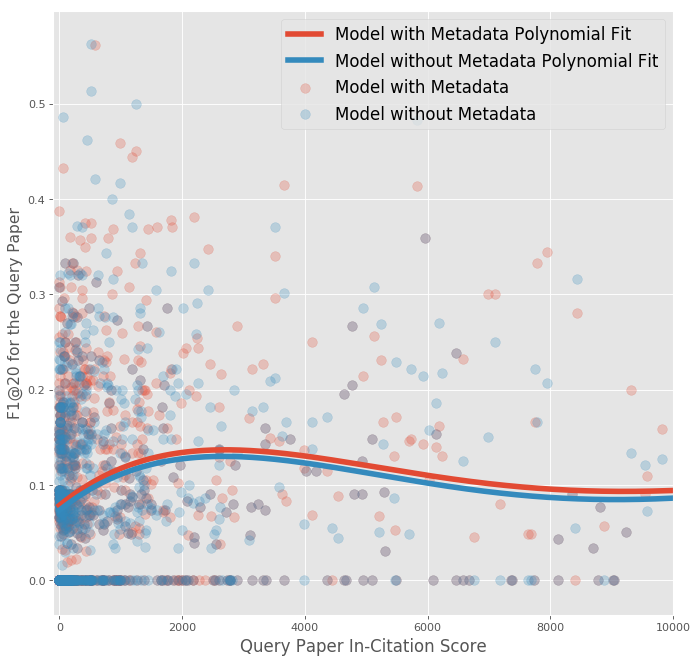

In [128]:
import matplotlib.pyplot as plt
import matplotlib

x_range = np.arange(0, 10000, 10)
poly = 5

with plt.style.context('ggplot'):
    plt.figure(0, figsize=(10, 10), dpi=80)
    plt.scatter(results1[:, 0], results1[:, 1], s=75, alpha=0.25, label='Model with Metadata')
    z = np.polyfit(results1[:, 0], results1[:, 1], poly)
    f = np.poly1d(z)
    plt.plot(x_range, f(x_range), linewidth=5.0, label='Model with Metadata Polynomial Fit')
    
    plt.scatter(results2[:, 0], results2[:, 1], s=75, alpha=0.25, label='Model without Metadata')
    z = np.polyfit(results2[:, 0], results2[:, 1], poly)
    f = np.poly1d(z)
    plt.plot(x_range, f(x_range), linewidth=5.0, label='Model without Metadata Polynomial Fit')
    
    plt.xlabel('Query Paper In-Citation Score', fontsize=15)
    plt.ylabel('F1@20 for the Query Paper', fontsize=14)
    plt.legend(fontsize=15)#, frameon=False)
    plt.xlim([-100, 10000])
    plt.show()